## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

## Load Data

#### Adult dataset

In [10]:
name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
test_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

test_df[label_name] = test_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
test_df[label_name] = encoder.transform(test_df[label_name])

adult_full_df = pd.concat([train_df, test_df], ignore_index=True)

In [30]:
cat_features_adult = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
                'race', 'sex', 'native-country']

In [29]:
adult_full_df = pd.get_dummies(adult_full_df, columns=cat_features_adult)

KeyError: "['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'] not in index"

In [ ]:
numeric_features_adult = list(set(adult_full_df.columns) - set(cat_features))

In [16]:
model_adult = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7460
           1       0.78      0.65      0.71      2309

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769

Accuracy: 0.8741938785955574


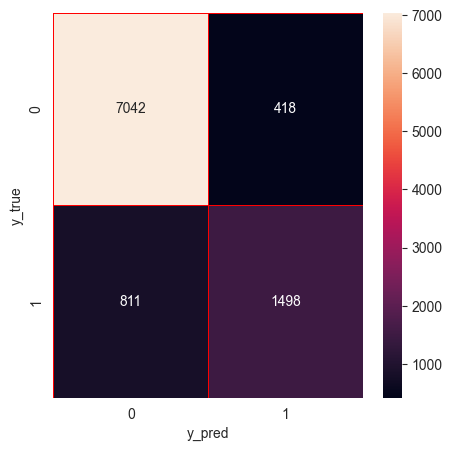

In [50]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = adult_full_df.drop(['income'],axis=1)
y = adult_full_df['income']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, shuffle=False,random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model_adult = lgb.LGBMClassifier()
model_adult.fit(X_train, y_train)
y_pred = model_adult.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [67]:
top_feats_df = pd.DataFrame({'Value':model_adult.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [68]:
top_feats = top_feats_df[top_feats_df['Value']>10].Feature.tolist()

In [69]:
top_feats

['age',
 'fnlwgt',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'education-num',
 'marital-status_ Married-civ-spouse',
 'occupation_ Exec-managerial',
 'workclass_ Self-emp-not-inc',
 'relationship_ Wife',
 'occupation_ Prof-specialty',
 'relationship_ Unmarried',
 'workclass_ Private',
 'sex_ Female',
 'occupation_ Other-service',
 'occupation_ Farming-fishing',
 'workclass_ Local-gov',
 'relationship_ Not-in-family',
 'workclass_ Federal-gov',
 'occupation_ Protective-serv',
 'occupation_ Sales',
 'occupation_ Tech-support',
 'occupation_ Machine-op-inspct',
 'marital-status_ Never-married',
 'workclass_ Self-emp-inc',
 'relationship_ Husband',
 'native-country_ United-States',
 'occupation_ Handlers-cleaners',
 'occupation_ Transport-moving',
 'native-country_ Mexico',
 'occupation_ Adm-clerical',
 'relationship_ Own-child',
 'race_ White',
 'education_ Some-college',
 'native-country_ Columbia',
 'education_ Masters',
 'race_ Black',
 'relationship_ Other-relative',
 'mar

In [71]:
adult_full_df_reduced = adult_full_df[top_feats]

In [72]:
column_mapping_adult = {
    "target": "income",
    "numerical_features": adult_full_df_reduced.columns,
    "categorical_features": [],
}

In [157]:
CT_dataset_adult = Dataset(
    full_df=adult_full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=10000
)

C:\Users\MarcellNemeth\Documents\BME\phd\fflab\test_harness\datasets\dataset.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MarcellNemeth\Documents\BME\phd\fflab\test_harness\datasets\dataset.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MarcellNemeth\Documents\BME\phd\fflab\test_harness\datasets\dataset.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [158]:
# plt.figure(figsize=(12,10))
# sns.heatmap(CT_dataset_adult.full_df.corr(), annot=True)
#
# plt.title('Adult dataset correlation map')
# plt.show()

## Run Experiments

In [159]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [160]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    #labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [161]:
corr_dict = windowed_correlation(CT_dataset_adult.full_df.loc[:, CT_dataset_adult.full_df.columns], mode='expanding')

In [162]:
#plot_windowed_correlation(corr_dict)

In [163]:
column_names = list(CT_dataset_adult.reference_df.columns[30:])

In [172]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=3000,
)

calc.fit(CT_dataset_adult.reference_df)

C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\nannyml\chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



In [173]:
results = calc.calculate(CT_dataset_adult.analysis_df)

In [174]:
results_js = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]
display(results_js)

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,occupation_ Adm-clerical_jensen_shannon_value,occupation_ Adm-clerical_jensen_shannon_upper_threshold,occupation_ Adm-clerical_jensen_shannon_lower_threshold,...,native-country_ Philippines_jensen_shannon_lower_threshold,native-country_ Philippines_jensen_shannon_alert,occupation_ Priv-house-serv_jensen_shannon_value,occupation_ Priv-house-serv_jensen_shannon_upper_threshold,occupation_ Priv-house-serv_jensen_shannon_lower_threshold,occupation_ Priv-house-serv_jensen_shannon_alert,sample_num_jensen_shannon_value,sample_num_jensen_shannon_upper_threshold,sample_num_jensen_shannon_lower_threshold,sample_num_jensen_shannon_alert
0,[0:2999],0,0,2999,None,None,analysis,0.008918,0.1,None,...,None,False,0.009468,0.1,None,False,0.999242,0.1,None,True
1,[3000:5999],1,3000,5999,None,None,analysis,0.008063,0.1,None,...,None,False,0.009468,0.1,None,False,1.000000,0.1,None,True
2,[6000:8999],2,6000,8999,None,None,analysis,0.007679,0.1,None,...,None,False,0.009468,0.1,None,False,1.000000,0.1,None,True
3,[9000:11999],3,9000,11999,None,None,analysis,0.004564,0.1,None,...,None,False,0.000427,0.1,None,False,1.000000,0.1,None,True
4,[12000:14999],4,12000,14999,None,None,analysis,0.002355,0.1,None,...,None,False,0.007307,0.1,None,False,1.000000,0.1,None,True
5,[15000:17999],5,15000,17999,None,None,analysis,0.011274,0.1,None,...,None,False,0.002624,0.1,None,False,1.000000,0.1,None,True
6,[18000:20999],6,18000,20999,None,None,analysis,0.024164,0.1,None,...,None,False,0.002624,0.1,None,False,1.000000,0.1,None,True
7,[21000:23999],7,21000,23999,None,None,analysis,0.019967,0.1,None,...,None,False,0.002624,0.1,None,False,1.000000,0.1,None,True
8,[24000:26999],8,24000,26999,None,None,analysis,0.009922,0.1,None,...,None,False,0.019619,0.1,None,False,1.000000,0.1,None,True
9,[27000:29999],9,27000,29999,None,None,analysis,0.002355,0.1,None,...,None,False,0.009468,0.1,None,False,1.000000,0.1,None,True


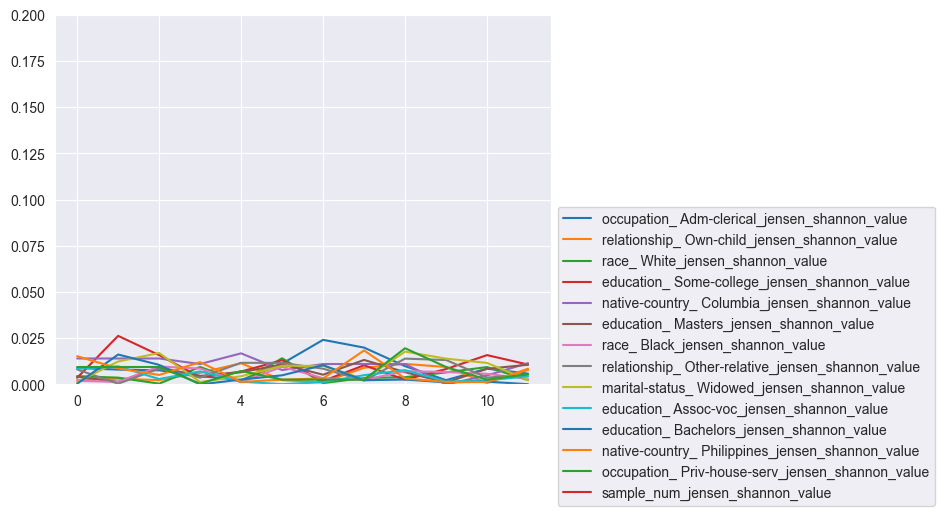

In [175]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]].plot(ylim=[0,0.2])
plt.legend(bbox_to_anchor=(1, 0.5))

In [139]:
#figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
#figure.show()

In [107]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### Own Jensen-Shannon

In [26]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=1000, radius_right=1000)
display(dde_exp_eq_radius.results_all)

122785 123785 124785
246570 247570 248570


C:\Users\MarcellNemeth\Documents\BME\phd\fflab\test_harness\experiments\dde_experiment.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MarcellNemeth\Documents\BME\phd\fflab\test_harness\experiments\dde_experiment.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MarcellNemeth\Documents\BME\phd\fflab\test_harness\experiments\dde_experiment.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

370355 371355 372355


C:\Users\MarcellNemeth\anaconda3\envs\pca_drift\lib\site-packages\nannyml\chunk.py:181: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



,start,change_point,end,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type,sample_num
0,122785,123785,124785,0.677523,0.044935,0.127194,0.354763,0.052703,0.575389,0.058876,0.080126,0.091013,0.281122,0.015273,0.003494,0.017127,0.024410,0.002565,0.99801
1,246570,247570,248570,0.082540,0.738349,0.995522,0.090822,0.975469,0.104845,0.974967,0.714436,0.844548,0.080445,0.003394,0.012981,0.001707,0.005743,0.013717,0.99801
2,370355,371355,372355,0.102926,0.090526,0.071732,0.080801,0.070375,0.079738,0.076800,0.054189,0.122517,0.092047,0.541940,0.365868,0.365998,0.542663,0.006838,0.99801


In [27]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=1000, radius_right=1000)

122785 123785 124785
246570 247570 248570
370355 371355 372355


#### Change point 1

In [28]:
dde_exp_eq_radius.corr_scores[123785]['reference']

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
elevation,1.000000,0.113262,-0.107275,0.254587,0.107896,0.225160,-0.019738,0.178264,0.121398,-0.005812,-0.074194,0.293780,-0.051586,-0.167524,-0.472416
aspect,0.113262,1.000000,0.040930,0.048018,0.085706,0.093875,-0.553944,0.421426,0.634532,-0.075016,-0.119261,0.079559,0.077403,0.031304,-0.023925
slope,-0.107275,0.040930,1.000000,0.038552,0.287666,-0.150567,-0.251319,-0.424437,-0.172299,-0.093417,-0.211997,-0.014114,0.216616,0.033690,0.085259
horizontal_dist_to_hydrology,0.254587,0.048018,0.038552,1.000000,0.575408,0.059654,-0.069723,0.084322,0.092072,0.053977,-0.142245,0.058207,0.120530,-0.054809,0.117451
vertical_dist_to_hydrology,0.107896,0.085706,0.287666,0.575408,1.000000,0.036474,-0.165036,-0.005153,0.078069,-0.003627,-0.165061,-0.019340,0.176895,-0.011255,0.116418
horizontal_dist_to_roadways,0.225160,0.093875,-0.150567,0.059654,0.036474,1.000000,-0.025418,0.172900,0.126158,0.273383,0.446747,-0.245640,-0.321413,-0.065821,-0.050993
hillshade_9am,-0.019738,-0.553944,-0.251319,-0.069723,-0.165036,-0.025418,1.000000,-0.143877,-0.823842,0.088692,0.181174,0.005351,-0.179672,-0.048279,0.038866
hillshade_noon,0.178264,0.421426,-0.424437,0.084322,-0.005153,0.172900,-0.143877,1.000000,0.657501,0.025591,-0.019655,0.043954,-0.001595,-0.002464,0.020962
hillshade_3pm,0.121398,0.634532,-0.172299,0.092072,0.078069,0.126158,-0.823842,0.657501,1.000000,-0.042049,-0.120490,0.020313,0.107467,0.034523,-0.037835
horizontal_dist_to_fire_points,-0.005812,-0.075016,-0.093417,0.053977,-0.003627,0.273383,0.088692,0.025591,-0.042049,1.000000,0.328827,0.057957,-0.353730,-0.052481,0.021979


In [29]:
for chp in CT_dataset.change_points[:1]:
    drift_threshold = 0.1
    summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

    corr_df = dde_exp_eq_radius.corr_scores[chp][ 'corr_delta']
    cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

    for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
        feat1 = list(pair)[0]
        feat2 = list(pair)[1]

        summary_df.loc[len(summary_df.index)] = [feat1, feat2, corr_df.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

    summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
    summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
    summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

    #summary_df.to_csv(f'delta_ro_chp_{chp}.csv')

In [33]:
summary_df = summary_df.sort_values(by=['corr_delta'], ascending=False)

In [40]:
def get_roc_auc(scores, ys):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [47]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [48]:
score = summary_df.corr_delta #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

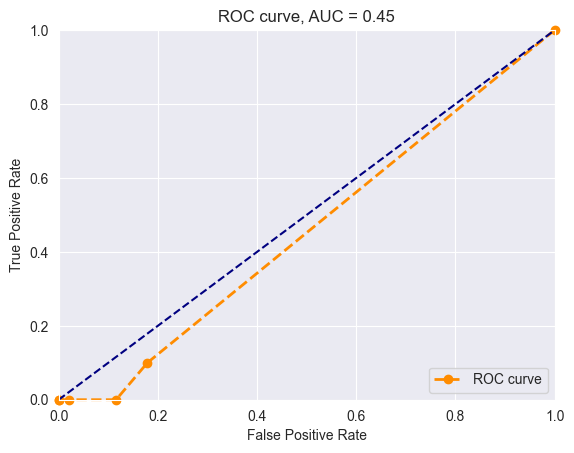

In [49]:
get_roc_auc(score, y)

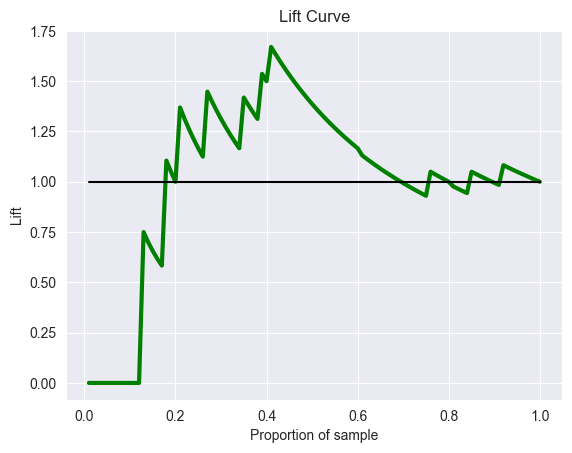

In [52]:
plot_lift_curve(score, y)